# Build the basin example base model

## Notebook Setup

In [1]:
import os
import sys
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.geometry import Polygon, LineString
import flopy
from flopy.discretization import StructuredGrid
import flopy.plot.styles as styles

In [2]:
# import all plot style information from defaults.py
from defaults import *

In [3]:
fine_topo = flopy.utils.Raster.load("./grid_data/fine_topo.asc")

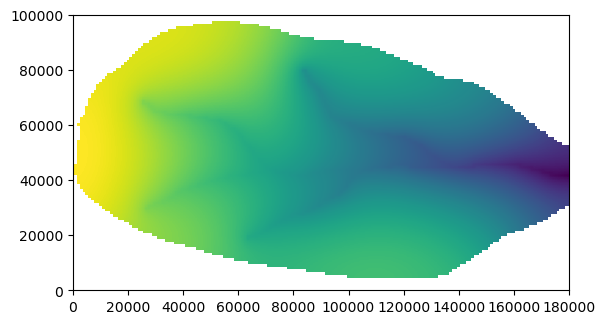

In [4]:
fine_topo.plot();

# Basin Example

len boundary 55
Len segment:  38
Len segment:  14
Len segment:  12
Len segment:  13


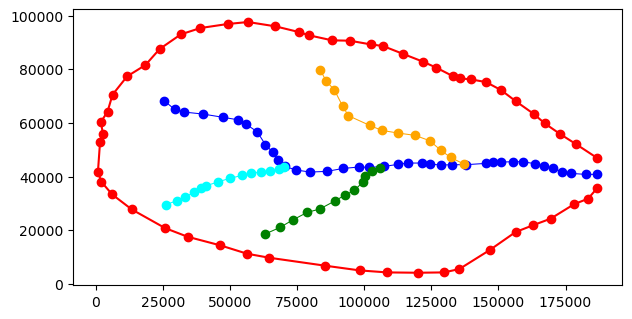

In [5]:
boundary_polygon = string2geom(boundary)
print("len boundary", len(boundary_polygon))
bp = np.array(boundary_polygon)

sgs = [
    string2geom(sg) for sg in (streamseg1, streamseg2, streamseg3, streamseg4)
]


fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
ax.set_aspect("equal")

riv_colors = ("blue", "cyan", "green", "orange", "red")

ax.plot(bp[:, 0], bp[:, 1], "ro-")
for idx, sg in enumerate(sgs):
    print("Len segment: ", len(sg))
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], color=riv_colors[idx], lw=0.75, marker="o")

In [6]:
def set_idomain(grid, boundary):
    from flopy.utils.gridintersect import GridIntersect
    from shapely.geometry import Polygon

    ix = GridIntersect(grid, method="vertex", rtree=True)
    result = ix.intersect(Polygon(boundary))
    idx = [coords for coords in result.cellids]
    idx = np.array(idx, dtype=int)
    nr = idx.shape[0]
    if idx.ndim == 1:
        idx = idx.reshape((nr, 1))
    print(idx.shape, idx.ndim)
    idx = tuple([idx[:, i] for i in range(idx.shape[1])])
    # idx = (idx[:, 0], idx[:, 1])
    idomain = np.zeros(grid.shape[1:], dtype=int)
    idomain[idx] = 1
    idomain = idomain.reshape(grid.shape)
    grid.idomain = idomain

In [7]:
# Create a regular MODFLOW grid
dx = dy = 500.0  # 166.666666667
dv0 = 5.0
nlay = 1
nrow = int(Ly / dy) + 1
ncol = int(Lx / dx) + 1
print(Lx, Ly, nrow, ncol)
delr = np.array(ncol * [dx])
delc = np.array(nrow * [dy])
top = np.ones((nrow, ncol)) * 1000.0
botm = np.ones((nlay, nrow, ncol)) * -100.0
regular_grid = StructuredGrid(
    nlay=nlay, delr=delr, delc=delc, xoff=0.0, yoff=0.0, top=top, botm=botm
)

set_idomain(regular_grid, boundary_polygon)

180000 100000 201 361
(49664, 2) 2


In [8]:
top_rg = fine_topo.resample_to_grid(
    regular_grid,
    band=fine_topo.bands[0],
    method="linear",
    extrapolate_edges=True,
)

In [9]:
regular_grid.shape

(1, 201, 361)

In [10]:
ixs = flopy.utils.GridIntersect(regular_grid, method="structured")
cellids = []
for sg in sgs:
    v = ixs.intersect(LineString(sg), sort_by_cellid=True)
    cellids += v["cellids"].tolist()
intersection_rg = np.zeros(regular_grid.shape[1:])
for loc in cellids:
    intersection_rg[loc] = 1

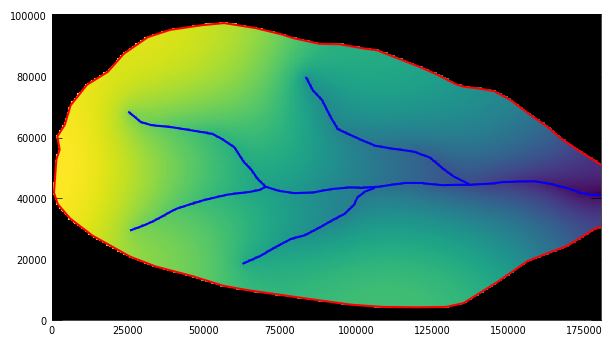

In [11]:
with styles.USGSMap():
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    pmv = flopy.plot.PlotMapView(modelgrid=regular_grid)
    ax.set_aspect("equal")
    pmv.plot_array(top_rg)
    pmv.plot_array(
        intersection_rg,
        masked_values=[
            0,
        ],
        alpha=0.2,
        cmap="Reds_r",
    )
    # pmv.plot_grid(lw=0.25, color="0.5")
    pmv.plot_inactive()
    # regular_grid.plot(ax=ax, )
    ax.plot(bp[:, 0], bp[:, 1], "r-")
    for sg in sgs:
        sa = np.array(sg)
        ax.plot(sa[:, 0], sa[:, 1], "b-")

### Build a model

In [12]:
sim_ws = "../examples/basin_base"

In [13]:
# redefine the number of layers
nlay = 5

In [14]:
newton_options = "NEWTON UNDER_RELAXATION"
linear_accelerator = "bicgstab"
outer_maximum = 1000
rewet_record = None
wetdry = None

In [15]:
drn_intersection = []
drn_cellids = []
drn_lengths = []
for sg in sgs:
    v = ixs.intersect(LineString(sg), sort_by_cellid=True)
    drn_intersection.append(v)
    drn_cellids += v["cellids"].tolist()
    drn_lengths += v["lengths"].tolist()

In [16]:
leakance = 1.0 / (0.5 * dv0)  # kv / b
drn_data = []
for (r, c), length in zip(drn_cellids, drn_lengths):
    x = regular_grid.xcellcenters[r, c]
    width = 5.0 + (14.0 / Lx) * (Lx - x)
    conductance = leakance * length * width
    drn_data.append((0, r, c, top_rg[r, c], conductance))
drn_data[:10]

[(0, 118, 360, 1.111111044883728, 998.4502422143426),
 (0, 118, 359, 1.111111044883728, 1006.2462842617487),
 (0, 118, 358, 2.071893483400345, 1014.0423263091567),
 (0, 118, 357, 2.349671334028244, 1021.8383683565637),
 (0, 118, 356, 2.627449095249176, 1029.6344104039706),
 (0, 118, 355, 2.905226767063141, 1037.4304524513766),
 (0, 118, 354, 3.1358508467674255, 1045.8339237471905),
 (0, 118, 353, 3.4136287569999695, 1069.443460192669),
 (0, 118, 352, 3.691406548023224, 1077.3610743876409),
 (0, 118, 351, 3.9691842198371887, 726.3278179798868)]

In [17]:
# groundwater discharge to surface
idomain = regular_grid.idomain[0].copy()
index = tuple(np.array(list(zip(*drn_cellids))))
idomain[index] = -1
gw_discharge_data = []
for r in range(nrow):
    for c in range(ncol):
        if idomain[r, c] < 1:
            continue
        conductance = leakance * dx * dy
        gw_discharge_data.append(
            (0, r, c, top_rg[r, c] - 0.5, conductance, 1.0)
        )
gw_discharge_data[:10]

[(0, 5, 110, 95.75077056884766, 100000.0, 1.0),
 (0, 5, 111, 95.75077056884766, 100000.0, 1.0),
 (0, 5, 112, 95.37101745605469, 100000.0, 1.0),
 (0, 5, 113, 95.37101745605469, 100000.0, 1.0),
 (0, 5, 114, 94.9806137084961, 100000.0, 1.0),
 (0, 5, 115, 94.9806137084961, 100000.0, 1.0),
 (0, 6, 100, 97.20894622802734, 100000.0, 1.0),
 (0, 6, 101, 97.19627952575684, 100000.0, 1.0),
 (0, 6, 102, 97.10438346862793, 100000.0, 1.0),
 (0, 6, 103, 96.96650314331055, 100000.0, 1.0)]

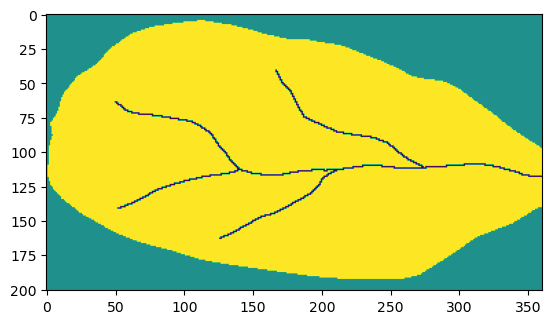

In [18]:
plt.imshow(idomain);

In [19]:
topc = np.zeros((nlay, nrow, ncol), dtype=float)
botm = np.zeros((nlay, nrow, ncol), dtype=float)
dv = dv0
topc[0] = top_rg.copy()
botm[0] = topc[0] - dv
for idx in range(1, nlay):
    dv *= 1.5
    topc[idx] = botm[idx - 1]
    botm[idx] = topc[idx] - dv

In [20]:
for k in range(nlay):
    print((topc[k] - botm[k]).mean())

5.0
7.5
11.25
16.875
25.3125


In [21]:
idomain = np.array(
    [regular_grid.idomain[0, :, :].copy() for k in range(nlay)], dtype=int
)
strt = np.array([top_rg.copy() for k in range(nlay)], dtype=float)

### Build the model files using FloPy

In [22]:
sim = flopy.mf6.MFSimulation(
    sim_name="basin",
    sim_ws=sim_ws,
    exe_name="mf6",
)

tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(
    sim,
    complexity="simple",
    print_option="SUMMARY",
    linear_acceleration=linear_accelerator,
    outer_maximum=outer_maximum,
    inner_maximum=100,
    outer_dvclose=1e-5,
    inner_dvclose=1e-6,
    relaxation_factor=0.0,
)
gwf = flopy.mf6.ModflowGwf(sim, save_flows=True, newtonoptions=newton_options)

dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=dx,
    delc=dy,
    idomain=idomain,
    top=top_rg,
    botm=botm,
    xorigin=0.0,
    yorigin=0.0,
)

ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_specific_discharge=True,
    icelltype=1,
    k=1.0,
    rewet_record=rewet_record,
    wetdry=wetdry,
)
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    iconvert=1,
    ss=1e-5,
    sy=0.2,
    steady_state=True,
)
rch = flopy.mf6.ModflowGwfrcha(
    gwf,
    recharge=0.000001,
)
drn = flopy.mf6.ModflowGwfdrn(
    gwf,
    stress_period_data=drn_data,
    pname="river",
)
drn_gwd = flopy.mf6.ModflowGwfdrn(
    gwf,
    auxiliary=["depth"],
    auxdepthname="depth",
    stress_period_data=gw_discharge_data,
    pname="gwd",
)
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{gwf.name}.hds",
    budget_filerecord=f"{gwf.name}.cbc",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("BUDGET", "ALL")],
)

### Write the model files

In [23]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package sto...
    writing package rcha_0...
    writing package river...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 817 based on size of stress_period_data
    writing package gwd...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 48848 based on size of stress_period_data
    writing package oc...


### Run the model

In [24]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                   VERSION 6.5.0 Release Candidate 06/07/2023
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Jun 07 2023 02:52:44 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that 

(True, [])

### Plot the heads for the full model

In [25]:
gwfhead = flopy.utils.postprocessing.get_water_table(
    gwf.output.head().get_data()
)
gwfhead_tot = gwf.output.head().get_data()
hmin, hmax = gwfhead.min(), gwfhead.max()
contours = np.arange(0, 100, 10)
hmin, hmax

(0.6860708687755249, 89.96203496974944)

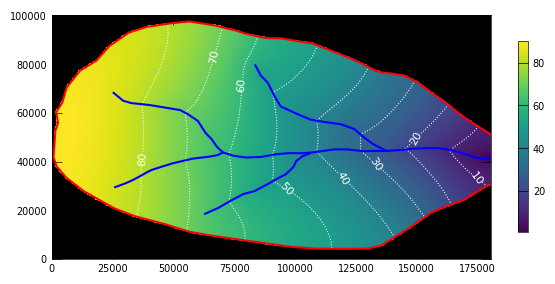

In [26]:
with styles.USGSMap():
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot()
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    ax.set_aspect("equal")
    pmv = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, ax=ax)
    h = pmv.plot_array(gwfhead_tot, vmin=hmin, vmax=hmax)
    c = pmv.contour_array(
        gwfhead,
        levels=contours,
        colors="white",
        linewidths=0.75,
        linestyles=":",
    )
    plt.clabel(c, fontsize=8)
    pmv.plot_inactive()
    plt.colorbar(h, ax=ax, shrink=0.35)

    ax.plot(bp[:, 0], bp[:, 1], "r-")
    for sg in sgs:
        sa = np.array(sg)
        ax.plot(sa[:, 0], sa[:, 1], "b-")